In [10]:
import sqlite3
from pathlib import Path

__file__ = %pwd
DATA = Path(__file__).parent / "data"
PRIORITIES = DATA / "Priorities"
DATABASE = DATA / "databases" / "exploration.db"
con = sqlite3.connect(DATABASE)
cur = con.cursor()

In [11]:
import pandas as pd
import numpy as np

df = pd.read_sql_query("SELECT * FROM ACGRWide", con)

df.replace('*', np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')
df.dropna(axis=1, how='all', inplace=True)
df.fillna(df.mean(), inplace=True)
df.fillna(0, inplace=True)


### Data Summary

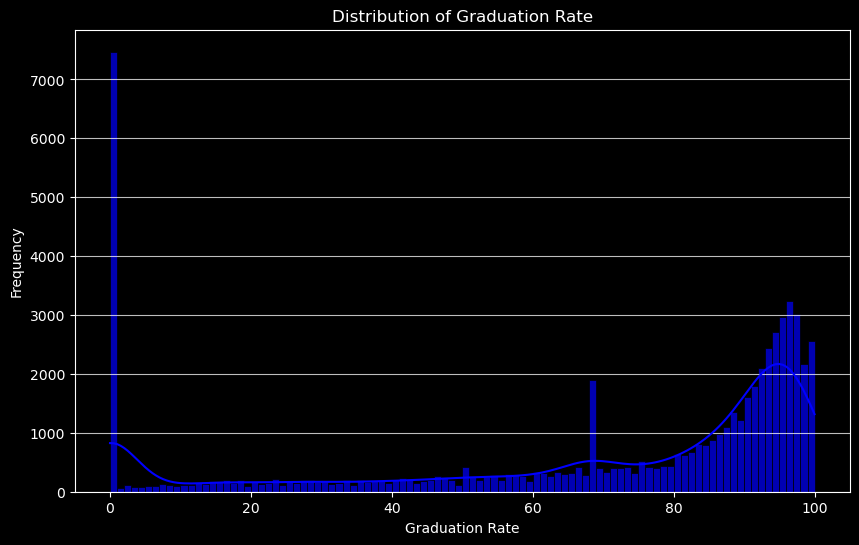

Mean Graduation Rate: 68.04490446940648


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df['RegHSDiplomaRate.TA'].dropna(), bins=100, kde=True, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Graduation Rate")
plt.ylabel("Frequency")
plt.title("Distribution of Graduation Rate")
plt.grid(axis='y', alpha=0.75)
plt.show()


mean_graduation_rate = df['RegHSDiplomaRate.TA'].mean()
print(f"Mean Graduation Rate: {mean_graduation_rate}")  

## Lasso Models

## Graduation Rate as Target Variable


UniReqsPercent.SS: 26.328703675433903
SPED.SE: 21.535868953864124
RegHSDiplomaRate.SS: 21.316033792224903
AdultEd.SS: -17.318575424777077
RegHSDiploma.GM: -10.881789351280093
RegHSDiploma.GF: -9.579787514026151
Other.SS: 9.014358404474013
RegHSDiplomaRate.GM: 6.058443196462315
RegHSDiplomaRate.GF: 4.755615614807731
RegHSDiploma.SS: 4.586694939088067
UniReqsPercent.GF: -4.403140775478537
Merit.SS: 3.9480020273819805
UniReqsPercent.GM: -3.682716158434739
Dropout.SS: 3.6671204101564383
GED.SS: 3.471114790581066
MeritRate.GM: -3.361344916177716
RegHSDiploma.SE: -3.329700389784788
Merit.SE: -3.0672553283207544
MeritRate.GF: -3.034062195749287
SPED.RT: 2.908449459534292
AdultEd.RW: -2.5107845532132758
Other.SE: -2.455956425632257
GED.SE: -2.2694731278861786
CohortStudents.GM: -2.0147425730139132
CohortStudents.GF: -1.8117262384393078
RegHSDiplomaRate.RT: -1.782757130031739
OtherRate.GM: -1.3633599176393092
RegHSDiplomaRate.SE: -1.2625537605919466
OtherRate.GF: -0.9788905192217503
UniReqsPer

/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.123e+03, tolerance: 7.048e+03
  model = cd_fast.enet_coordinate_descent(


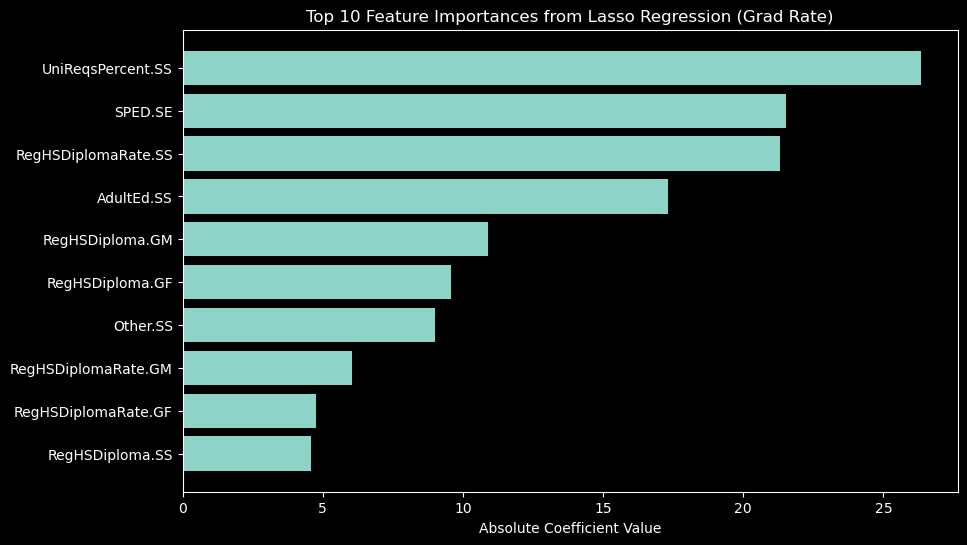

In [18]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline


target_column = "RegHSDiplomaRate.TA"

X = df.drop(columns=[target_column])
y = df[target_column]

# Remove low-variance features
selector = VarianceThreshold(threshold=0.01)
X_reduced = selector.fit_transform(X)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(cv=5, random_state=42, max_iter=10000)) 
])


# Fit the model
pipe.fit(X_reduced, y)

# Get the coefficients of the Lasso model
lasso_coefficients = pipe['lasso'].coef_


coef_feature_pairs = list(zip(X.columns, lasso_coefficients))
sorted_pairs = sorted(coef_feature_pairs, key=lambda x: abs(x[1]), reverse=True)
print()
for feature, coef in sorted_pairs:
    print(f"{feature}: {coef}")

# Plot top 10 feature importances
top_n = 10
top_features = sorted_pairs[:top_n]

plt.figure(figsize=(10, 6))
plt.barh([f[0] for f in top_features], [abs(f[1]) for f in top_features])
plt.xlabel("Absolute Coefficient Value")
plt.title("Top 10 Feature Importances from Lasso Regression (Grad Rate)")
plt.gca().invert_yaxis()
plt.show()

### Graduation Rate Model Validation

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, max)

pipe.fit(X_train, y_train)

# Make predictions
y_pred = pipe.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_2 = pipe.score(X_test, y_test)

print(f"R^2 Score: {r_2}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Best alpha value: {pipe['lasso'].alpha_}")

R^2 Score: 0.9392707143564978
Mean Squared Error: 70.94209397671182
Root Mean Squared Error: 8.422712981973909
Best alpha value: 0.03143022433298659


/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.990e+03, tolerance: 5.635e+03
  model = cd_fast.enet_coordinate_descent(


### Graduation Rate Residuals

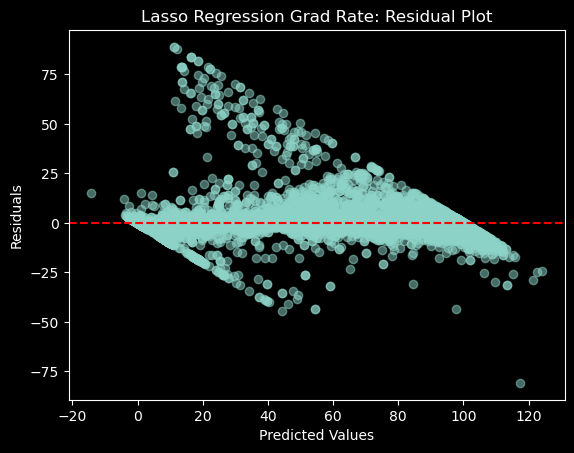

In [16]:
y_test_numeric = pd.to_numeric(y_test, errors='coerce')

# Calculate residuals
residuals = y_test_numeric - y_pred

# Plot residuals
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Lasso Regression Grad Rate: Residual Plot")
plt.show()

### Graduation Rate Actual vs. Predicted

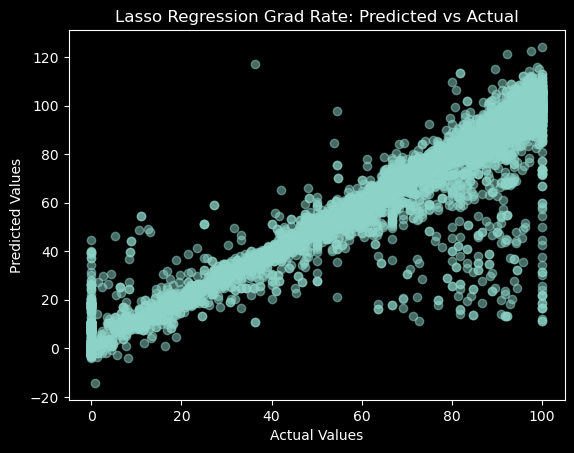

In [17]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Lasso Regression Grad Rate: Predicted vs Actual")
plt.show()

## CSU/UC Readiness as Target Variable

### CSU/UC Readiness Model Validation

### CSU/UC Readiness Residuals


### CSU/UC Readiness Actual vs. Predicted

# XGBoost Models

## Graduation Rate as Target

### Model Validation

### Residuals

### Actual vs. Predicted

## CSU/UC Readiness as Target

### Model Validation

### Residuals

### Actual vs. Predicted

In [14]:
con.close()